In [1]:
import numpy as np
print(np.__version__)
import math
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)
from tqdm.auto import trange
import random

2.2.4
2.8.0+cu129


In [5]:
class ConnectFour:
    def __init__(self):
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count
        self.in_a_row = 4
        
    def __repr__(self):
        return "ConnectFour"
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state
    
    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0 
                    or r >= self.row_count
                    or c < 0 
                    or c >= self.column_count
                    or state[r][c] != player
                ):
                    return i - 1
            return self.in_a_row - 1

        return (
            count(1, 0) >= self.in_a_row - 1 # vertical
            or (count(0, 1) + count(0, -1)) >= self.in_a_row - 1 # horizontal
            or (count(1, 1) + count(-1, -1)) >= self.in_a_row - 1 # top left diagonal
            or (count(1, -1) + count(-1, 1)) >= self.in_a_row - 1 # top right diagonal
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)

        if len(state.shape)==3: #batch,rows,columns incase of parallel so len =3 else it just just rows,columns len=2
            encoded_state = np.swapaxes(encoded_state,0,1)            
        
        return encoded_state

In [7]:
class ResNet(nn.Module):
    def __init__(self,game,num_resBlocks,num_hidden,device):
        super().__init__()
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3,num_hidden,kernel_size =3,padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden,32,kernel_size =3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*game.row_count * game.column_count,game.action_size)
        )
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden,3,kernel_size =3,padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3*game.row_count * game.column_count,1),
            nn.Tanh()
        )
        self.to(device)

        
    def forward(self,x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy,value
        


class ResBlock(nn.Module):
    def __init__(self,num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden,num_hidden,kernel_size = 3,padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden,num_hidden,kernel_size = 3,padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
    
    def forward(self,x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x+=residual
        x = F.relu(x)
        return x
           

In [11]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None,prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        self.children = []
        # self.expandable_moves = game.get_valid_moves(state)
        
        self.visit_count = visit_count
        self.value_sum = 0
        
    def is_fully_expanded(self):
        # return np.sum(self.expandable_moves) == 0 and len(self.children) > 0
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count==0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count+1))*child.prior
    
    def expand(self,policy):
        for action,prob in enumerate(policy):
            if prob>0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)
                child = Node(self.game, self.args, child_state, self, action,prob)
                self.children.append(child)
               
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args,model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state,visit_count=1)

        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state),device = self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy,axis = 1).squeeze(0).cpu().numpy()
        
        # add noise to our model
        policy = (1-self.args['dirichlet_epsilon'])*policy + \
            self.args['dirichlet_epsilon']*np.random.dirichlet([self.args['dirichlet_alpha']]*self.game.action_size)

        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            if not is_terminal:
                policy,value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state),device = self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy,axis =1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy*=valid_moves
                policy/=np.sum(policy)

                value = value.item()
                node.expand(policy)
                
            node.backpropagate(value)    
            
            
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs        

In [13]:
class AlphaZero:
    def __init__(self,model,optimizer,game,args):
        self.model = model
        self.optimizer = optimizer
        self.args = args
        self.game = game
        self.mcts = MCTS(game,args,model)

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            neutral_state = self.game.change_perspective(state,player)
            action_probs = self.mcts.search(neutral_state)

            memory.append((neutral_state,action_probs,player))
            
            temperature_action_probs = action_probs ** (1/self.args['temperature'])
            temperature_action_probs /=np.sum(temperature_action_probs)
            action = np.random.choice(self.game.action_size, p=temperature_action_probs)
            state = self.game.get_next_state(state,action,player)
            value,is_terminal = self.game.get_value_and_terminated(state,action)
            if is_terminal:
                returnMemory = []
                for hist_neutral_state,hist_action_probs,hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((self.game.get_encoded_state(hist_neutral_state),
                                        hist_action_probs,
                                        hist_outcome))
                return returnMemory
            player = self.game.get_opponent(player)
            
        
        
    def train(self,memory):
        random.shuffle(memory)
        for batchIdx in range(0,len(memory),self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory)-1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1,1)

            state = torch.tensor(state,dtype = torch.float32, device = self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype = torch.float32, device = self.model.device)
            value_targets = torch.tensor(value_targets, dtype = torch.float32, device = self.model.device)

            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy,policy_targets)
            value_loss = F.mse_loss(out_value,value_targets)
            loss = policy_loss+value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory+=self.selfPlay()
            self.model.train()
            for epoch in range(self.args['num_epochs']):
                self.train(memory)
            torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")

In [15]:
class MCTSParallel:
    def __init__(self, game, args,model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, states, spGames):
        
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(states),device = self.model.device)
        )
        policy = torch.softmax(policy,axis = 1).cpu().numpy()
        
        # add noise to our model
        policy = (1-self.args['dirichlet_epsilon'])*policy + \
            self.args['dirichlet_epsilon']*np.random.dirichlet([self.args['dirichlet_alpha']]*self.game.action_size, size=policy.shape[0])

        for i,spg in enumerate(spGames):
            spg_policy = policy[i]
            valid_moves = self.game.get_valid_moves(states[i])
            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)
    
            spg.root = Node(self.game, self.args, states[i],visit_count=1)
            spg.root.expand(spg_policy)
        
        for search in range(self.args['num_searches']):
            for spg in spGames:
                spg.node = None
                node = spg.root
                
                while node.is_fully_expanded():
                    node = node.select()
                    
                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)
                
                if is_terminal:
                        node.backpropagate(value)   
                else:
                    spg.node = node
            
            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]
            
            if len(expandable_spGames)>0:
                states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])
                
                policy,value = self.model(
                    torch.tensor(self.game.get_encoded_state(states),device = self.model.device)
                )
                policy = torch.softmax(policy,axis =1).cpu().numpy()
                value = value.cpu().numpy()

            for i,mappingIdx in enumerate(expandable_spGames):
                node = spGames[mappingIdx].node
                spg_policy,spg_value = policy[i],value[i]
                
                valid_moves = self.game.get_valid_moves(node.state)
                spg_policy*=valid_moves
                spg_policy/=np.sum(spg_policy)

                node.expand(spg_policy)
                node.backpropagate(spg_value)    

In [17]:
class AlphaZeroParallel:
    def __init__(self,model,optimizer,game,args):
        self.model = model
        self.optimizer = optimizer
        self.args = args
        self.game = game
        self.mcts = MCTSParallel(game,args,model)

    def selfPlay(self):
        return_memory = []
        player = 1
        spGames = [SPG(self.game) for _ in range(self.args['num_parallel_games'])]

        while len(spGames)>0:
            states = np.stack([spg.state for spg in spGames])
            
            neutral_states = self.game.change_perspective(states,player)
            self.mcts.search(neutral_states, spGames)

            for i in range(len(spGames))[::-1]:
                spg = spGames[i]
                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
    
                spg.memory.append((spg.root.state,action_probs,player))
                
                temperature_action_probs = action_probs ** (1/self.args['temperature'])
                temperature_action_probs /= np.sum(temperature_action_probs)
                action = np.random.choice(self.game.action_size, p=temperature_action_probs)
                
                spg.state = self.game.get_next_state(spg.state,action,player)
                value,is_terminal = self.game.get_value_and_terminated(spg.state,action)
                
                if is_terminal:
                    for hist_neutral_state,hist_action_probs,hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append((self.game.get_encoded_state(hist_neutral_state),
                                            hist_action_probs,
                                            hist_outcome))
                    del spGames[i]
            player = self.game.get_opponent(player)
                
        return return_memory
            
        
    def train(self,memory):
        random.shuffle(memory)
        for batchIdx in range(0,len(memory),self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory)-1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1,1)

            state = torch.tensor(state,dtype = torch.float32, device = self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype = torch.float32, device = self.model.device)
            value_targets = torch.tensor(value_targets, dtype = torch.float32, device = self.model.device)

            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy,policy_targets)
            value_loss = F.mse_loss(out_value,value_targets)
            loss = policy_loss+value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
                memory+=self.selfPlay()
            self.model.train()
            for epoch in range(self.args['num_epochs']):
                self.train(memory)
            torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")

class SPG:
    def __init__(self,game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None

In [86]:
game = ConnectFour()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game,9,128,device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001, weight_decay = 0.0001)
args = {
    'C':2,
    'num_searches':600,
    'num_iterations':6,
    'num_selfPlay_iterations':500,
    'num_parallel_games':250,
    'num_epochs':4,
    'batch_size':128,
    'temperature':1.25,
    'dirichlet_epsilon':0.25,
    'dirichlet_alpha':0.3
}

alphaZero = AlphaZeroParallel(model,optimizer,game,args)
alphaZero.learn()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
game = ConnectFour()
player = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'C': 2,
    'num_searches': 100,
    'dirichlet_epsilon':0.0,
    'dirichlet_alpha':0.3
}

model = ResNet(game,9,128,device)
model.load_state_dict(torch.load("model_5_ConnectFour.pt", map_location=device))
model.eval()

mcts = MCTS(game, args,model)

state = game.get_initial_state()


while True:
    print(state)
    
    if player == 1:
        valid_moves = game.get_valid_moves(state)
        print("valid_moves", [i for i in range(game.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = game.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = game.get_next_state(state, action, player)
    
    value, is_terminal = game.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = game.get_opponent(player)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]


1: 1


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]


1: 1


[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]


1: 0


[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0. -1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -1. -1.  0.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]


1: 0


[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -1. -1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -1. -1. -1.  0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6]


1: 1


[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -1. -1. -1.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0. -1. -1. -1. -1.]]
-1 won


In [74]:
import pygame
import sys 
import time
from pygame import gfxdraw

pygame 2.6.1 (SDL 2.28.4, Python 3.13.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [75]:
# ---------- Layout / scaling ----------
MARGIN = 16  # pixels margin on all sides
MAX_SQUARE = 140  # max pixel size per square to avoid huge tiles on large monitors
MIN_SQUARE = 60   # minimum size to keep things playable

# These will be computed in `init_layout()` based on the user's display and game size
SQUARESIZE = None
RADIUS = None
OFFSET_X = None
OFFSET_Y = None
WIDTH = None
HEIGHT = None
SIZE = None
FPS = 60

BLACK = (0,0,0)
WHITE = (255,255,255)
BLUE = (13, 71, 161)
RED = (220, 20, 60)     # player == 1 (human)
YELLOW = (240, 200, 0)  # player == -1 (model)
GREEN = (50,205,50)


def init_layout(game, scale=0.85):
    global SQUARESIZE, RADIUS, OFFSET_X, OFFSET_Y, WIDTH, HEIGHT, SIZE

    pygame.init()
    info = pygame.display.Info()
    screen_w, screen_h = info.current_w, info.current_h

    cols = game.column_count
    rows = game.row_count
    # reserve space for the top preview row as well: (rows + 1)
    available_w = max(300, screen_w - 2*MARGIN)
    available_h = max(400, screen_h - 2*MARGIN)

    # compute square limited by width and height
    sq_w = (available_w - 2*MARGIN) // cols
    sq_h = (available_h - 2*MARGIN) // (rows + 1)

    # apply scale to make everything a bit smaller
    computed = int(min(sq_w, sq_h) * scale)

    SQUARESIZE = int(max(MIN_SQUARE, min(MAX_SQUARE, computed)))
    RADIUS = int(SQUARESIZE/2 - 6)

    # compute final window size with margins
    WIDTH = cols * SQUARESIZE + 2*MARGIN
    HEIGHT = (rows + 1) * SQUARESIZE + 2*MARGIN
    OFFSET_X = MARGIN
    OFFSET_Y = MARGIN
    SIZE = (WIDTH, HEIGHT)

    return SIZE

# ---------- Drawing helpers (single final update per frame) ----------

def draw_board(surface, state, game, highlight_positions=None, preview_col=None):
    """
    Draws the board to `surface`. `state` uses values: 0 empty, 1 human, -1 model.
    preview_col: optional column index to show the preview disc at the top (no update here).
    """
    surface.fill(BLACK)

    cols = game.column_count
    rows = game.row_count

    # draw grid and discs
    for c in range(cols):
        for r in range(rows):
            x = OFFSET_X + c*SQUARESIZE
            y = OFFSET_Y + (r+1)*SQUARESIZE
            pygame.draw.rect(surface, BLUE, (x, y, SQUARESIZE, SQUARESIZE))
            val = int(state[r, c])
            center = (int(x + SQUARESIZE/2), int(y + SQUARESIZE/2))
            if val == 0:
                pygame.draw.circle(surface, BLACK, center, RADIUS)
            elif val == 1:
                pygame.draw.circle(surface, RED, center, RADIUS)
            elif val == -1:
                pygame.draw.circle(surface, YELLOW, center, RADIUS)

    # draw preview disc at top (if any) using the preview_col
    if preview_col is not None and 0 <= preview_col < cols:
        px = OFFSET_X + preview_col*SQUARESIZE + SQUARESIZE//2
        py = OFFSET_Y + SQUARESIZE//2
        pygame.draw.circle(surface, RED, (px, py), RADIUS)

    # highlight winning positions
    if highlight_positions:
        for (r,c) in highlight_positions:
            cx = OFFSET_X + c*SQUARESIZE + SQUARESIZE//2
            cy = OFFSET_Y + (r+1)*SQUARESIZE + SQUARESIZE//2
            pygame.draw.circle(surface, GREEN, (cx, cy), RADIUS, 6)


def animate_drop(surface, state, game, col, player_value, fps=FPS):
    """
    Animate a disc falling into column `col` (visually). This routine updates
    the display while animating and returns once the disc has visually landed.
    It does NOT modify the logical `state` (the caller should call get_next_state).
    """
    cols = game.column_count
    rows = game.row_count

    # find the bottom-most empty row
    open_row = None
    for r in range(rows-1, -1, -1):
        if state[r, col] == 0:
            open_row = r
            break
    if open_row is None:
        return

    x = OFFSET_X + col*SQUARESIZE + SQUARESIZE//2
    target_y = OFFSET_Y + (open_row+1)*SQUARESIZE + SQUARESIZE//2
    y = OFFSET_Y + SQUARESIZE//2

    clock = pygame.time.Clock()
    vel = 0.0
    acc = 2.8
    color = RED if player_value == 1 else YELLOW

    while y < target_y:
        clock.tick(fps)
        vel += acc
        y += vel
        # draw board and falling disc
        draw_board(surface, state, game)
        pygame.draw.circle(surface, color, (x, min(int(y), target_y)), RADIUS)
        pygame.display.update()

    # final frame
    draw_board(surface, state, game)
    pygame.draw.circle(surface, color, (x, target_y), RADIUS)
    pygame.display.update()


# ---------- Model/MCTS integration helper ----------
def get_model_action_from_mcts(game, mcts, state, player):
    valid = game.get_valid_moves(state)
    valid_indices = [i for i in range(game.action_size) if valid[i] == 1]
    if len(valid_indices) == 0:
        return None
    if mcts is None:
        return int(random.choice(valid_indices))
    try:
        neutral_state = game.change_perspective(state.copy(), player)
        mcts_probs = mcts.search(neutral_state)
        action = int(np.argmax(mcts_probs))
        if valid[action] == 1:
            return action
        for idx in np.argsort(-np.array(mcts_probs)):
            if valid[int(idx)] == 1:
                return int(idx)
    except Exception as e:
        print("Warning: mcts/model inference failed:", e)
    return int(random.choice(valid_indices))


# ---------- Main GUI loop ----------
def run_gui(game, state, mcts=None, human_value=1, model_value=-1, model_move_delay_ms=600):
    # initialize layout based on display
    size = init_layout(game)
    screen = pygame.display.set_mode(size)
    pygame.display.set_caption("Connect Four - GUI")
    font = pygame.font.SysFont("Arial", max(18, SQUARESIZE//5))
    small_font = pygame.font.SysFont("Arial", max(14, SQUARESIZE//6))
    clock = pygame.time.Clock()

    assert state.shape == (game.row_count, game.column_count), "State shape mismatch with game dimensions."

    player = human_value
    play_vs_model = True if mcts is not None else False
    game_over = False
    highlight = None
    info_text = "Your turn (Red). Click a column to drop."
    last_model_move_time = 0
    preview_col = None  # column index under mouse for preview

    # initial draw
    draw_board(screen, state, game, highlight_positions=highlight, preview_col=None)
    pygame.display.update()

    running = True
    while running:
        clock.tick(FPS)
        # event handling
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    running = False
                    break
                if event.key == pygame.K_r:
                    state[:] = game.get_initial_state()
                    player = human_value
                    game_over = False
                    highlight = None
                    info_text = "Your turn (Red). Click a column to drop."
                if event.key == pygame.K_m:
                    play_vs_model = not play_vs_model
                    state[:] = game.get_initial_state()
                    player = human_value
                    game_over = False
                    highlight = None
                    info_text = "Mode toggled. " + ("Human vs Model." if play_vs_model else "Human vs Human.")

            if event.type == pygame.MOUSEMOTION:
                mx, my = event.pos
                # compute column under mouse taking margins into account
                col = (mx - OFFSET_X) // SQUARESIZE
                if 0 <= col < game.column_count:
                    preview_col = int(col)
                else:
                    preview_col = None

            if event.type == pygame.MOUSEBUTTONDOWN:
                if game_over:
                    state[:] = game.get_initial_state()
                    player = human_value
                    game_over = False
                    preview_col = None
                    highlight = None
                    info_text = "Your turn (Red). Click a column to drop."
                    continue

                mx, my = event.pos
                col = (mx - OFFSET_X) // SQUARESIZE
                if col < 0 or col >= game.column_count:
                    continue

                if player == human_value:
                    valid_moves = game.get_valid_moves(state)
                    if valid_moves[col] == 0:
                        info_text = "Invalid move. Choose another column."
                    else:
                        animate_drop(screen, state, game, col, player)
                        state = game.get_next_state(state, int(col), player)
                        val, terminated = game.get_value_and_terminated(state, int(col))
                        if terminated:
                            game_over = True
                            if val == 1:
                                info_text = f"{player} (You) won! Press R to restart."
                            else:
                                info_text = "Draw! Press R to restart."
                            highlight = None
                        else:
                            if play_vs_model:
                                player = model_value
                                info_text = "Model thinking..."
                                last_model_move_time = pygame.time.get_ticks()
                            else:
                                player = model_value
                                info_text = "Player 2's turn."

                else:
                    valid_moves = game.get_valid_moves(state)
                    if valid_moves[col] == 0:
                        info_text = "Invalid move. Choose another column."
                    else:
                        animate_drop(screen, state, game, col, player)
                        state = game.get_next_state(state, int(col), player)
                        val, terminated = game.get_value_and_terminated(state, int(col))
                        if terminated:
                            game_over = True
                            if val == 1:
                                info_text = f"{player} (Player 2) won! Press R to restart."
                            else:
                                info_text = "Draw! Press R to restart."
                            highlight = None
                        else:
                            player = human_value
                            info_text = "Your turn (Red)."

        # model turn (non-blocking)
        if not game_over and play_vs_model and player == model_value:
            now = pygame.time.get_ticks()
            if now - last_model_move_time >= model_move_delay_ms:
                action = get_model_action_from_mcts(game, mcts, state.copy(), player)
                if action is None:
                    game_over = True
                    info_text = "No valid moves: draw."
                else:
                    animate_drop(screen, state, game, action, player)
                    state = game.get_next_state(state, int(action), player)
                    val, terminated = game.get_value_and_terminated(state, int(action))
                    if terminated:
                        game_over = True
                        if val == 1:
                            info_text = f"{player} (Model) won! Press R to restart."
                        else:
                            info_text = "Draw! Press R to restart."
                        highlight = None
                    else:
                        player = human_value
                        info_text = "Your turn (Red)."

        # final draw (single update per frame)
        draw_board(screen, state, game, highlight_positions=highlight, preview_col=preview_col if (not game_over and player==human_value) else None)
        info_surf = font.render(info_text, True, WHITE)
        screen.blit(info_surf, (OFFSET_X + 6, OFFSET_Y + 6))
        mode_text = f"Mode: {'Human vs Model' if play_vs_model else 'Human vs Human'}  |  Press M to toggle, R to restart, Q to quit"
        mode_surf = small_font.render(mode_text, True, WHITE)
        screen.blit(mode_surf, (OFFSET_X + 6, HEIGHT - OFFSET_Y - small_font.get_height() - 6))
        pygame.display.update()

    pygame.quit()
    sys.exit()

In [80]:
game = ConnectFour()
state = game.get_initial_state()
player = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'C': 2,
    'num_searches': 100,
    'dirichlet_epsilon':0.0,
    'dirichlet_alpha':0.3
}

model = ResNet(game,9,128,device)
model.load_state_dict(torch.load("model_5_ConnectFour.pt", map_location=device))
model.eval()

mcts = MCTS(game, args,model)

state = game.get_initial_state()

run_gui(game,state,mcts= mcts)

SystemExit: 

In [43]:
class HeuristicAgent:
    def __init__(self, game):
        self.game = game

    def select_action(self, state, player):
        valid_moves = self.game.get_valid_moves(state)
        valid_actions = np.where(valid_moves == 1)[0]

        # 1. Try to play a winning move for current player
        for a in valid_actions:
            tmp = state.copy()
            tmp = self.game.get_next_state(tmp, a, player)
            value, is_terminal = self.game.get_value_and_terminated(tmp, a)
            # value = 1 means the player who just moved (player) wins
            if is_terminal and value == 1:
                return int(a)

        # 2. Try to block opponent's immediate win
        opp = self.game.get_opponent(player)
        for a in valid_actions:
            tmp = state.copy()
            tmp = self.game.get_next_state(tmp, a, opp)
            value, is_terminal = self.game.get_value_and_terminated(tmp, a)
            if is_terminal and value == 1:
                return int(a)

        # 3. Otherwise prefer center columns
        # center preference: [3,2,4,1,5,0,6] for a 7-column board
        center_order = sorted(valid_actions, key=lambda c: abs(c - (self.game.column_count // 2)))
        return int(center_order[0])

class MCTSAgent:
    def __init__(self, game, model, args_eval):
        self.game = game
        self.model = model
        self.args = args_eval.copy()
        # disable root noise for evaluation
        self.args['dirichlet_epsilon'] = 0.0
        self.mcts = MCTS(game, self.args, model)

    def select_action(self, state, player):
        neutral_state = self.game.change_perspective(state, player)
        action_probs = self.mcts.search(neutral_state)
        return int(np.argmax(action_probs))  # greedy for evaluation


def play_game_with_length(game, agent1, agent2):
    """
    Returns (result, moves)
    result: +1 if agent1 wins, -1 if agent2 wins, 0 if draw
    moves: number of moves played
    """
    state = game.get_initial_state()
    current_player = 1
    moves = 0

    while True:
        if current_player == 1:
            action = agent1.select_action(state, current_player)
        else:
            action = agent2.select_action(state, current_player)

        state = game.get_next_state(state, action, current_player)
        moves += 1
        value, is_terminal = game.get_value_and_terminated(state, action)
        if is_terminal:
            if value == 1:
                return (1 if current_player == 1 else -1), moves
            else:
                return 0, moves
        current_player = game.get_opponent(current_player)


def evaluate_vs_heuristic_for_checkpoint(game, args, ckpt_path,
                                         num_games=40, mcts_search_override=200, device=None):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

    # load model
    model = ResNet(game, num_resBlocks=9, num_hidden=128, device=device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    args_eval = args.copy()
    args_eval['dirichlet_epsilon'] = 0.0
    if mcts_search_override is not None:
        args_eval['num_searches'] = mcts_search_override

    mcts_agent = MCTSAgent(game, model, args_eval)
    heuristic_agent = HeuristicAgent(game)

    wins = losses = draws = 0
    moves_list = []

    wins_as_first = wins_as_second = 0
    games_as_first = games_as_second = 0

    for i in range(num_games):
        if i % 2 == 0:
            # model as player 1 (agent1)
            result, moves = play_game_with_length(game, mcts_agent, heuristic_agent)
            games_as_first += 1
            if result == 1:
                wins_as_first += 1
        else:
            # heuristic as player 1, model as player -1 (agent2)
            result, moves = play_game_with_length(game, heuristic_agent, mcts_agent)
            result = -result  # flip perspective to keep +1 = model win
            games_as_second += 1
            if result == 1:
                wins_as_second += 1

        moves_list.append(moves)

        if result == 1:
            wins += 1
        elif result == -1:
            losses += 1
        else:
            draws += 1

    total = wins + losses + draws
    win_rate = wins / total if total > 0 else 0.0
    avg_moves = float(np.mean(moves_list)) if moves_list else 0.0

    win_rate_first = wins_as_first / games_as_first if games_as_first > 0 else 0.0
    win_rate_second = wins_as_second / games_as_second if games_as_second > 0 else 0.0

    return {
        "checkpoint": ckpt_path,
        "games": total,
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": win_rate,
        "avg_moves": avg_moves,
        "win_rate_first": win_rate_first,
        "win_rate_second": win_rate_second,
    }

In [45]:
game = ConnectFour()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []
for i in range(0, 6):
    ckpt = f"model_{i}_{game}.pt"  # or "model_{}_ConnectFour.pt"
    res = evaluate_vs_heuristic_for_checkpoint(
        game, args, ckpt, num_games=30, mcts_search_override=200, device=device
    )
    print(res)
    results.append(res)

{'checkpoint': 'model_0_ConnectFour.pt', 'games': 30, 'wins': 15, 'losses': 15, 'draws': 0, 'win_rate': 0.5, 'avg_moves': 18.0, 'win_rate_first': 1.0, 'win_rate_second': 0.0}
{'checkpoint': 'model_1_ConnectFour.pt', 'games': 30, 'wins': 15, 'losses': 0, 'draws': 15, 'win_rate': 0.5, 'avg_moves': 24.5, 'win_rate_first': 1.0, 'win_rate_second': 0.0}
{'checkpoint': 'model_2_ConnectFour.pt', 'games': 30, 'wins': 30, 'losses': 0, 'draws': 0, 'win_rate': 1.0, 'avg_moves': 14.5, 'win_rate_first': 1.0, 'win_rate_second': 1.0}
{'checkpoint': 'model_3_ConnectFour.pt', 'games': 30, 'wins': 30, 'losses': 0, 'draws': 0, 'win_rate': 1.0, 'avg_moves': 18.5, 'win_rate_first': 1.0, 'win_rate_second': 1.0}
{'checkpoint': 'model_4_ConnectFour.pt', 'games': 30, 'wins': 30, 'losses': 0, 'draws': 0, 'win_rate': 1.0, 'avg_moves': 20.5, 'win_rate_first': 1.0, 'win_rate_second': 1.0}
{'checkpoint': 'model_5_ConnectFour.pt', 'games': 30, 'wins': 15, 'losses': 0, 'draws': 15, 'win_rate': 0.5, 'avg_moves': 31.5, 

In [64]:
def collect_first_move_stats(game, model, args_eval, num_games=50, device=None):
    """
    Returns vector of shape (7,) — frequency of each column as model's first move.
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.eval()
    agent = MCTSAgent(game, model, args_eval)

    counts = np.zeros(game.action_size, dtype=int)

    for _ in range(num_games):
        state = game.get_initial_state()
        player = 1
        neutral_state = game.change_perspective(state, player)
        action_probs = agent.mcts.search(neutral_state)
        first_action = int(np.argmax(action_probs))
        counts[first_action] += 1

    return counts

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
game = ConnectFour()

args_eval = args.copy()
args_eval["dirichlet_epsilon"] = 0.0        # no exploration noise
args_eval["num_searches"] = 200             # smaller search for speed

models = [f"model_{i}_ConnectFour.pt" for i in range(6)]
heatmap_data = []

for ckpt in models:
    model = ResNet(game, 9, 128, device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    counts = collect_first_move_stats(game, model, args_eval, num_games=40, device=device)
    heatmap_data.append(counts)

heatmap_data = np.array(heatmap_data)

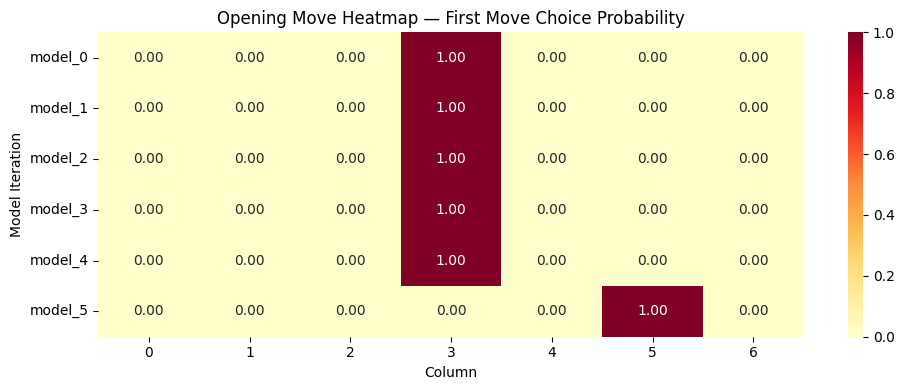

In [65]:
heatmap_probs = heatmap_data / heatmap_data.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 4))
sns.heatmap(
    heatmap_probs,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    xticklabels=range(heatmap_probs.shape[1]),
    yticklabels=[f"model_{i}" for i in range(len(models))]
)

plt.xlabel("Column")
plt.ylabel("Model Iteration")
plt.title("Opening Move Heatmap — First Move Choice Probability")
plt.tight_layout()
plt.show()